<a href="https://colab.research.google.com/github/HENILCHOPRA/pytorch-learning/blob/main/pytorch_104.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import tarfile
from torchvision.datasets.utils import download_url

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

import torch.nn.functional as F
import torch.nn as nn

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

import torchvision.transforms as tt

In [ ]:
# dataset_url = "http://files.fast.ai/data/cifar10.tgz"
# download_url(dataset_url, '/content/')

In [ ]:
with tarfile.open("/content/cifar10.tgz") as tar:
  tar.extractall(path = "/content/")

In [ ]:
data_dir = "/content/cifar10"
classes = os.listdir(data_dir + '/train')
classes

['horse',
 'truck',
 'automobile',
 'airplane',
 'dog',
 'frog',
 'bird',
 'deer',
 'cat',
 'ship']

In [ ]:
import matplotlib.pyplot as plt

def show_example(img, label):
  print('label: ', dataset.classes[label])

  plt.imshow(img.permute([1,2,0]))

In [ ]:
# show_example(*dataset[10000])

In [ ]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
# only for current dataset. Mean and Standard deviation of images for normalization 
train_tfms = tt.Compose([tt.RandomCrop(32, padding = 4, padding_mode = 'reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor(),
                        tt.Normalize(*stats)])
val_tfms = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])


In [ ]:
dataset_train = ImageFolder(data_dir + '/train', transform = train_tfms)
dataset_test = ImageFolder(data_dir + '/test', transform = val_tfms)

In [ ]:
batch_size = 256

train_dl = DataLoader(dataset_train, batch_size, shuffle= True,
                      num_workers=8,pin_memory= True)
test_dl = DataLoader(dataset_test, batch_size, shuffle= True,
                      num_workers=8,pin_memory= True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [ ]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (16,16))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images[:100], 10).permute(1,2,0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


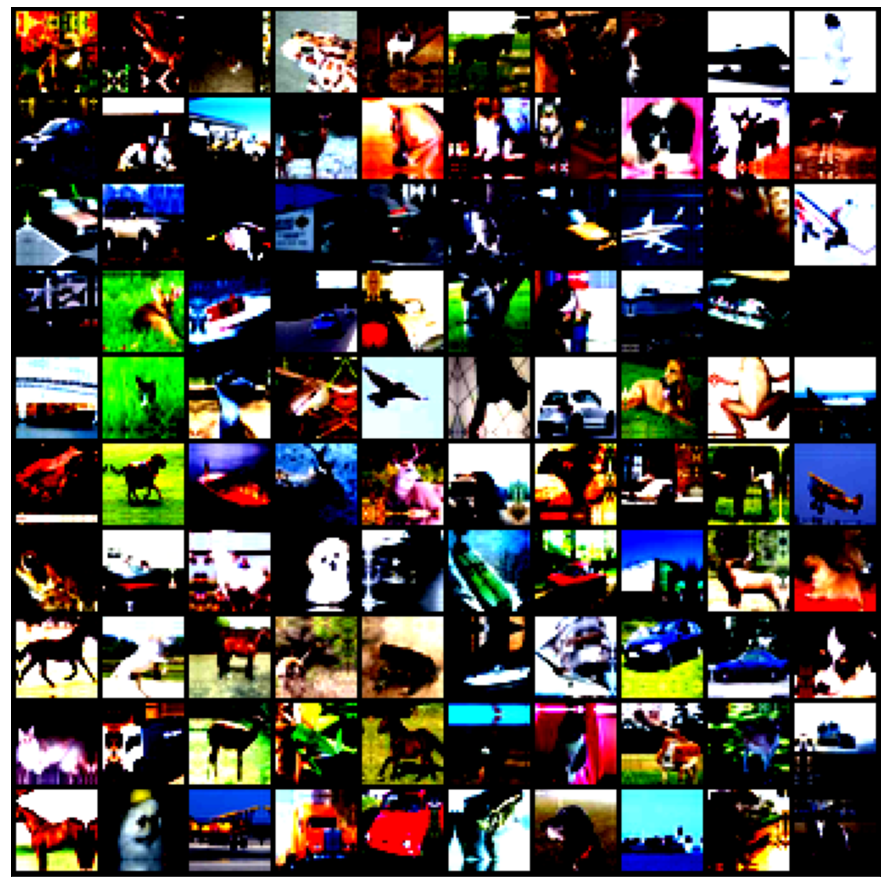

In [ ]:
show_batch(train_dl)

*RNN Model*

In [ ]:
class simpleRNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels= 3, out_channels= 3, kernel_size = 3, stride = 1, padding = 1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels= 3, out_channels= 3, kernel_size = 3, stride = 1, padding = 1)
    self.relu2 = nn.ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    return self.relu2(out + x)
    # here we have added the original input which retain number of channels
    # We can also concatinate out with original input which will increase the channels
    # We use 1x1 conv layer to change number of channels

In [ ]:
srnn = simpleRNN()
for images, labels in train_dl:
  out = srnn(images)
  print(out.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 3, 32, 32])


![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)
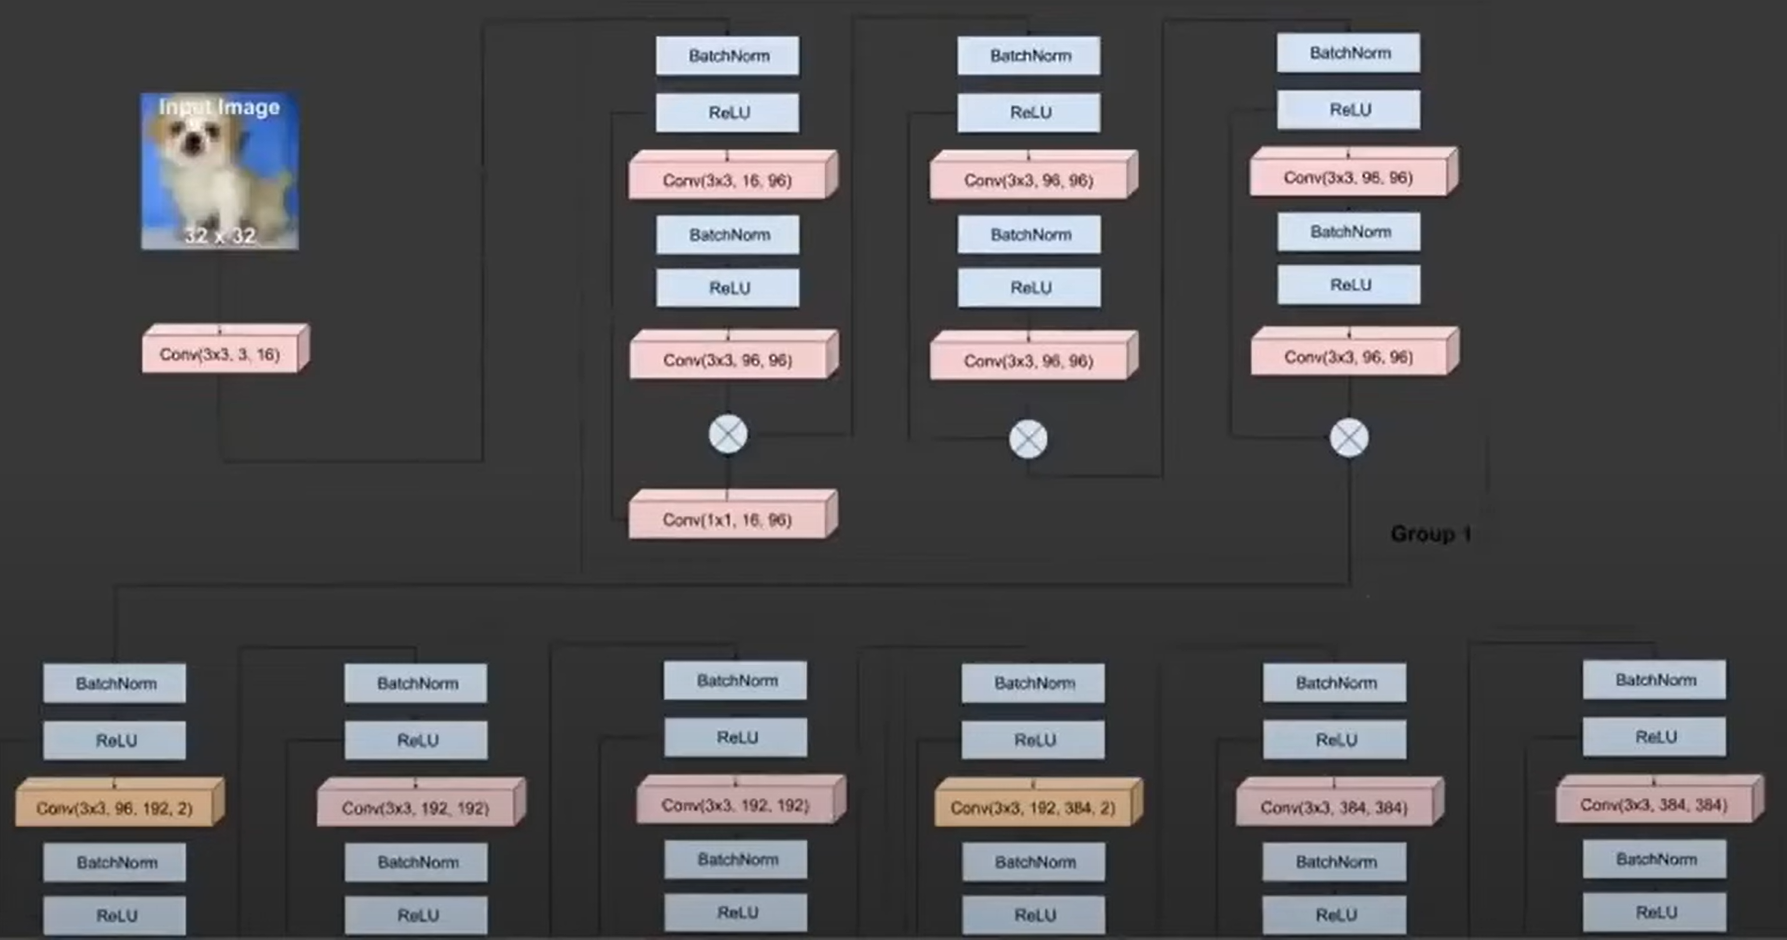

In [ ]:
def conv_2d(ni, nf, stride = 1, ks = 3):
  return nn.Conv2d(in_channels = ni, out_channels = nf,
                   kernel_size = ks, stride = stride,
                   padding = ks//2, bias = False)
  
def bn_relu_conv(ni, nf):
  return nn.Sequential(nn.BatchNorm2d(ni),
                       nn.ReLU(inplace = True),
                       conv_2d(ni, nf))
  
class ResidualBlock(nn.Module):
  def __init__(self, ni, nf, stride = 1):
    super().__init__()
    self.bn = nn.BatchNorm2d(ni)
    self.conv1 = conv_2d(ni, nf, stride)
    self.conv2 = bn_relu_conv(nf, nf)
    self.shortcut = lambda x: x
    if ni != nf:
      self.shortcut = conv_2d(ni, nf, stride, 1)

  def forward(self, x):
      x = F.relu(self.bn(x), inplace = True)
      r = self.shortcut(x)
      x = self.conv1(x)
      x = self.conv2(x) * 0.2
      return x.add_(r)

In [ ]:
def make_group(N, ni, nf, stride):
  start = ResidualBlock(ni, nf, stride)
  rest = [ResidualBlock(nf, nf) for j in range(1, N)]
  return [start] + rest

class Flatten(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return x.view(x.size(0), -1)

class WideResNet(nn.Module):
  def __init__(self, n_groups, N, num_classes, k = 1, n_start = 16):
      super().__init__()

      layers = [conv_2d(3, n_start)]
      n_channels = [n_start]

      for i in range(n_groups):
        n_channels.append(n_start * (2 ** i)*k)
        stride = 2 if i>0 else 1
        layers += make_group(N, n_channels[i],
                            n_channels[i+1], stride)
        
      layers += (nn.BatchNorm2d(n_channels[3]),
                nn.ReLU(inplace = True),
                nn.AdaptiveAvgPool2d(1),
                Flatten(),
                nn.Linear(n_channels[3], num_classes))
      self.features = nn.Sequential(*layers)

  def forward(self, x):
      return self.features(x)

def wrn22():
  return WideResNet(n_groups= 3, N = 3, num_classes = 10, k = 6)


In [ ]:
model = wrn22()

In [ ]:
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
for images, labels in train_dl:
  print(images.shape)
  out = model(images)
  print(out.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 3, 32, 32])
torch.Size([256, 10])


In [ ]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

In [ ]:
data = DataBunch.create(dataset_train, dataset_test, bs = batch_size, path = "/content/cifar10")
# Does all steps to prepare data for training and loading to available device
learner = Learner(data, model, loss_func = F.cross_entropy, metrics = [accuracy])
#learner is encapsulation of data and model 
learner.clip = 0.1
#bounds gradients in range [-0.1, 0.1]

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


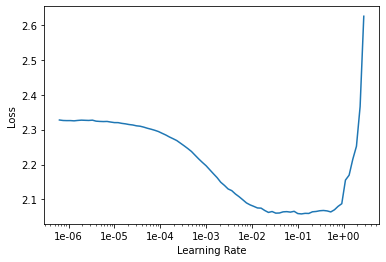

In [ ]:
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(9, 5e-3, wd = 1e-4)
#wd: weight decay

epoch,train_loss,valid_loss,accuracy,time
0,1.285133,1.670904,0.466400,05:40
1,0.940408,1.576027,0.536500,05:43
2,0.726299,0.840844,0.716000,05:38
3,0.572352,0.613693,0.789600,05:37
4,0.466166,0.464330,0.840300,05:37
5,0.359530,0.396396,0.862100,05:37
6,0.272459,0.304217,0.896300,05:37
7,0.203594,0.273982,0.910700,05:37
8,0.167597,0.269722,0.911600,05:37


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/wrn22.pth')